<a href="https://colab.research.google.com/github/yannuma/PrivacyProject/blob/main/Model_Creation/Federated_Learning_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Learning with and without Privacy Mechanism
---

In this notebook we create our federated learning models, assuming that the data is distributed to multiple clients (in our case different hospitals).  
The aim is to create and analyse the difference between FL with and without privacy.

We initially wanted to use the PySyft library for this. However, since older tutorials no longer work, there were problems with the various clients.  PySyft also does not provide any methods for model aggregation. We simply simulated FL without libraries and therefore without sending the trained models.


In [ ]:
# install and import necessary libraries
!pip install opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
import tarfile
import torch
import requests
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision
import torch.utils.data as torch_data
import torchvision.transforms as transforms
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
#Download the dataset and save features and labels in two different lists
response = requests.get(f'https://www.comp.nus.edu.sg/~reza/files/dataset_texas.tgz')
if response.status_code == 200:
    with open(f'dataset_texas.tgz', 'wb') as file:
        file.write(response.content)
    print("Download completed successfully.")
else:
    print(f"Failed to download file: {response.status_code}")

with tarfile.open(f'dataset_texas.tgz') as f:
    f.extractall(f'data/')

with open('data/texas/100/feats', 'r') as f:
    features = f.readlines()
with open('data/texas/100/labels', 'r') as f:
    labels = f.readlines()

print(len(features))
print(len(labels))

features_list = [list(map(int, ''.join(feature.split()).split(','))) for feature in features]
labels_list = [int(label.strip()) for label in labels]

Download completed successfully.
67330
67330


In [ ]:
'''
Classical Network Architecture:
3 Linear Layers
This neural network consists of three linear layers.
The first and second layers use the Tanh activation function, while the third layer outputs the final predictions.
Input size is 6169, and it outputs 101 classes with two hidden layers of size 128.
Tanh activation function (somehow) works better than classic activation function like Relu for DPSG.
'''
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()
        self.fc1 = nn.Linear(6169, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 101)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

'''
Function to calculate the acuracy of a network for a given dataset.
Device decides if the calculations happens on CPU or GPU.
'''
def calc_accuracy(loader, network, device):
    correct = 0
    total = 0
    for data in loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = network(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    return (correct / total, total)

In [ ]:
"""
Each client has to train their own model.
Classical train algorithm, same implementation as if there are no clients.
"""
def train_client(trainloader, testloader, lr = 0.01, epochs = 2, network_output = True):
    test_accs = []
    max_accuracy = 0
    best_model_path = 'best_model.pth'

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = NetSeq().to(device)
    optimizer = torch.optim.Adam(network.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    #print('Start training on', device)

    for epoch in range(epochs):

      #print('Epoch: {}'.format(epoch + 1))
      for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

      # Validate all classes
      with torch.no_grad():
        acc_tuple = calc_accuracy(testloader, network, device)

      #print('Accuracy of the network on %d test inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
      test_accs.append(acc_tuple[0])
      if acc_tuple[0] > max_accuracy:
        max_accuracy = acc_tuple[0]
        if network_output:
          torch.save(network.state_dict(), best_model_path)

    if network_output:
      network.load_state_dict(torch.load(best_model_path))
      network.to('cpu')
      #print('Final accuracy: ', max_accuracy)
      return (network, max_accuracy)
    else:
      #print('Final accuracy: ', max_accuracy)
      return max_accuracy

"""
Each client has to train their own model but with DPSGD using opacus.
Classical train algorithm: same implementation as if there are no clients.
"""
def train_client_DP(trainloader, testloader, lr = 0.001, epochs = 80, network_output = True, C = 3, epsilon = 10):
		test_accs = []
		max_accuracy = 0
		best_model_path = 'best_model.pth'
		Delta = 1e-5

		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

		network = NetSeq().to(device)
		network = ModuleValidator.fix(network)
		network = network.to(device)
		optimizer = torch.optim.Adam(network.parameters(), lr = lr)
		criterion = nn.CrossEntropyLoss()

    #define privacy engine
		privacy_engine = PrivacyEngine()
    #feed the network, optimizer, trainloader to the privacy engine
		network, optimizer, trainloader = privacy_engine.make_private_with_epsilon(
    	module=network,
    	optimizer=optimizer,
    	data_loader=trainloader,
    	max_grad_norm=C,
			target_epsilon = epsilon,
			target_delta = Delta,
			epochs = epochs
			)

		network.to(device)

		#print('Start training on', device)
		for epoch in range(epochs):

			#print('Epoch: {}'.format(epoch + 1))
			for i, data in enumerate(trainloader, 0):
				inputs, labels = data
				inputs, labels = inputs.to(device), labels.to(device)
				optimizer.zero_grad()
				outputs = network(inputs)
				loss = criterion(outputs, labels)
				loss.backward()
				optimizer.step()

			# Validate all classes
			with torch.no_grad():
				acc_tuple = calc_accuracy(testloader, network, device)

			#print('Accuracy of the network on %d test inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			test_accs.append(acc_tuple[0])
			if acc_tuple[0] > max_accuracy:
				max_accuracy = acc_tuple[0]
				if network_output:
					torch.save(network.state_dict(), best_model_path)

		epsilon = privacy_engine.get_epsilon(delta=Delta)
		#print("Our Privacy Budget is:", epsilon)

		if network_output:
			network.load_state_dict(torch.load(best_model_path))
			network.to('cpu')
			#print('Final accuracy: ', max_accuracy)
			return (network, max_accuracy)
		else:
			#print('Final accuracy: ', max_accuracy)
			return max_accuracy

"""
aggregate the client models to one model
the methode used here is just averaging the parameters (there are more advanced techniques)
"""
def aggregate_models(models):
  for model in models:
    model.eval()

  num_models = len(models)
  aggregated_params = {}

  for model in models:
      for name, param in model.named_parameters():
          if name in aggregated_params:
              aggregated_params[name] += param.data
          else:
              aggregated_params[name] = param.data.clone()

  # Calculate the average of aggregated parameters
  for name in aggregated_params:
      aggregated_params[name] /= num_models

  # Create a new model with the averaged parameters
  aggregated_model = type(models[0])()
  aggregated_model.load_state_dict(aggregated_params)

  return aggregated_model

In [ ]:
#Choose the number of clients
clients = 2

#Distribute the Dataset to the clients (In Practice every clients has already their own data)
dataset = TensorDataset(torch.tensor(features_list, dtype=torch.float), torch.tensor(labels_list, dtype=torch.long))
client_size = len(dataset) // clients
sizes = [client_size] * (clients - 1) + [len(dataset) - client_size * (clients - 1)]
client_datasets = random_split(dataset, sizes)
train_loaders = []
test_loaders = []
batch = 64

for client_dataset in client_datasets:
    train_size = int(0.8 * len(client_dataset))
    train_subset, test_subset = torch.utils.data.random_split(client_dataset, [train_size, len(client_dataset) - train_size])
    train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)
    train_loaders.append(train_loader)
    test_loader = DataLoader(test_subset, batch_size=batch, shuffle=False)
    test_loaders.append(test_loader)

# Federated Learning without Privacy

In [ ]:
epochs = [5, 10, 20, 40, 60]

results = []
agg_model = []
for epoch in epochs:
  client_models = []

  #Train the clients
  for client in range(clients):
    start = time.time()
    res = train_client(train_loaders[client], test_loaders[client], 0.001, epoch)
    end = time.time()
    client_models.append(res[0])
    results.append({'Mode': "Training Client", 'client': client, 'epoch': epoch, 'accuracy': res[1], "time": end - start})

  #aggegrate the model
  start = time.time()
  aggegrated_model = aggregate_models(client_models)
  end = time.time()
  agg_model.append(aggegrated_model)
  #calculate the accuracy for each client on the testset
  for client in range(clients):
      with torch.no_grad():
        acc = calc_accuracy(test_loaders[client], aggegrated_model, device = 'cpu')
        results.append({'Mode': "Aggregated Model", 'client': client, 'epoch': epoch, 'accuracy': acc[0], "time": end - start})

#group the data, to find the best model
df = pd.DataFrame(results)
agg_model_df = df[df['Mode'] == "Aggregated Model"]
average_accuracy_per_epoch = agg_model_df.groupby('epoch')['accuracy'].mean()
max_epoch = average_accuracy_per_epoch.idxmax()
max_average_accuracy = average_accuracy_per_epoch.max()

print("Average Accuracy per Epoch for Aggregated Model:")
print(average_accuracy_per_epoch)
print("\nMaximum Average Accuracy for Aggregated Model:")
print(f"Epoch: {max_epoch}, Accuracy: {max_average_accuracy}")
df.to_csv('df_results_FL.csv', index=False)
files.download('df_results_FL.csv')

Average Accuracy per Epoch for Aggregated Model:
epoch
5     0.589559
10    0.594831
20    0.580425
40    0.587628
60    0.589559
Name: accuracy, dtype: float64

Maximum Average Accuracy for Aggregated Model:
Epoch: 10, Accuracy: 0.5948314272983811


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#download the model
epoch_index = epochs.index(max_epoch)
best_model = agg_model[epoch_index]
torch.save(best_model.state_dict(), 'model_FL.pth')
files.download('model_FL.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Federated Learning with Privacy

In [ ]:
#Do exactly the same as above but with Differential Privacy Mechanism
epsilons = [1, 10, 20]
epochs = [5, 10, 20, 40, 60]
results_DP = []

#train the models for different epsilons and epochs
for eps in epsilons:
  for epoch in epochs:
    client_models = []
    for client in range(clients):
      start = time.time()
      res = (train_client_DP(train_loaders[client], test_loaders[client], epochs = epoch, epsilon = eps))
      end = time.time()
      client_models.append(res[0]._module)
      results_DP.append({'Mode': "Training Client", 'client': client, 'epsilon': eps,'epoch': epoch, 'accuracy': res[1], 'time': end - start})

    #aggregate the models
    start = time.time()
    aggegrated_model = aggregate_models(client_models)
    end = time.time()

    #calculate the accuracy for the aggregated model
    for client in range(clients):
        with torch.no_grad():
          device = 'cpu'
          acc = calc_accuracy(test_loaders[client], aggegrated_model, device)
          results_DP.append({'Mode': "Aggregated Model", 'client': client, 'epsilon': eps,'epoch': epoch, 'accuracy': acc[0], 'time': end - start})

#group the data, to find the best model
df_DP = pd.DataFrame(results_DP)
agg_model_df = df_DP[df_DP['Mode'] == "Aggregated Model"]
average_accuracy_per_epoch_epsilon = agg_model_df.groupby(['epoch', 'epsilon'])['accuracy'].mean()
print(average_accuracy_per_epoch_epsilon)

max_accuracy_per_epsilon = average_accuracy_per_epoch_epsilon.groupby('epsilon').idxmax().apply(
    lambda x: (x[0], average_accuracy_per_epoch_epsilon.loc[x])
)
max_accuracy_per_epsilon = max_accuracy_per_epsilon.rename("epoch, accuracy").reset_index()
print("Maximum Average Accuracy per Epsilon:")
print(max_accuracy_per_epsilon)

df_DP.to_csv('df_results_FL_DP.csv', index=False)
files.download('df_results_FL_DP.csv')

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


epoch  epsilon
5      1          0.168498
       10         0.250928
       20         0.265855
10     1          0.239046
       10         0.329051
       20         0.330685
20     1          0.279667
       10         0.397371
       20         0.430789
40     1          0.314793
       10         0.422917
       20         0.462275
60     1          0.306104
       10         0.397297
       20         0.424551
Name: accuracy, dtype: float64
Maximum Average Accuracy per Epsilon:
   epsilon            epoch, accuracy
0        1    (40, 0.314792811525323)
1       10   (40, 0.4229169760879251)
2       20  (40, 0.46227536016634485)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Train again the best model to download them
#(we could not save all models and extract the best ones because it took too much RAM)
epsilons = [1, 10, 20]
epoch = 40
for eps in epsilons:
  client_models = []
  for client in range(clients):
    res = (train_client_DP(train_loaders[client], test_loaders[client], epochs = epoch, epsilon = eps))
    client_models.append(res[0]._module)

  aggegrated_model = aggregate_models(client_models)
  torch.save(aggegrated_model.state_dict(), f'model_FL_epsilon_{eps}.pth')
  files.download(f'model_FL_epsilon_{eps}.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plotting the Results

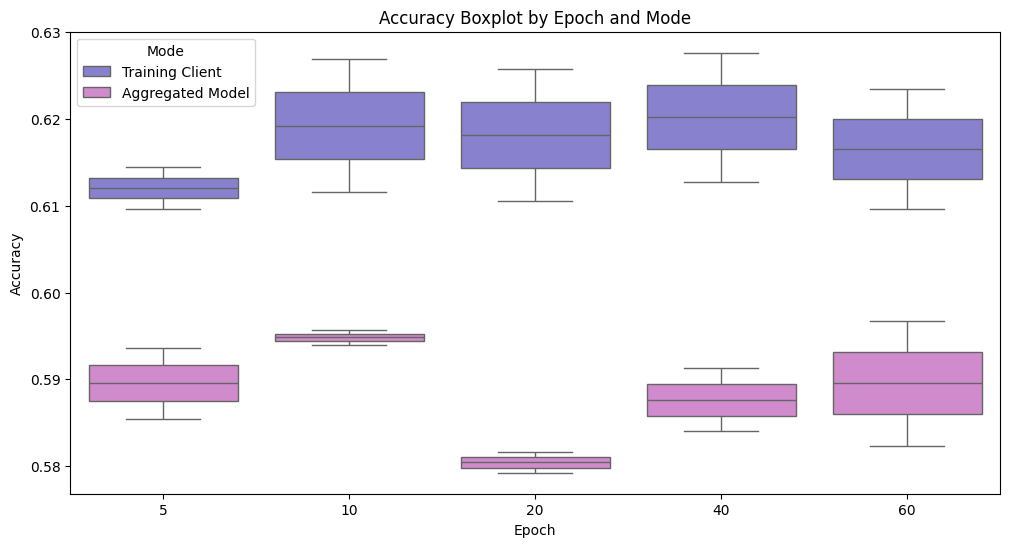

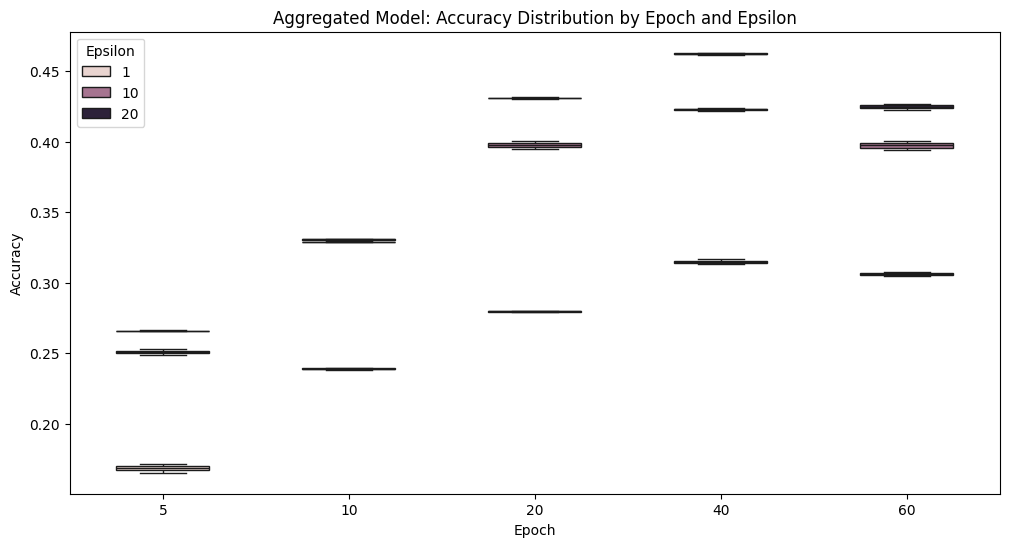

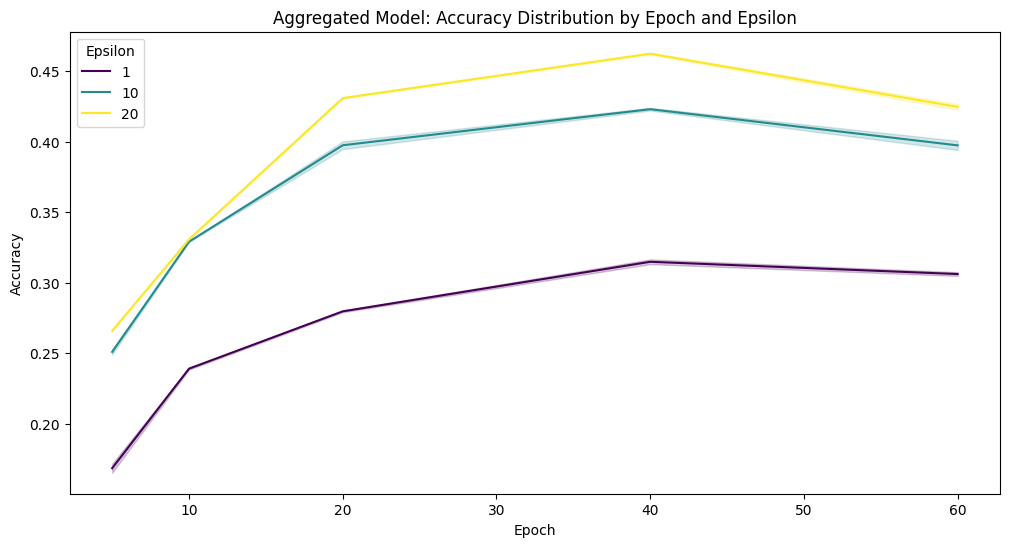

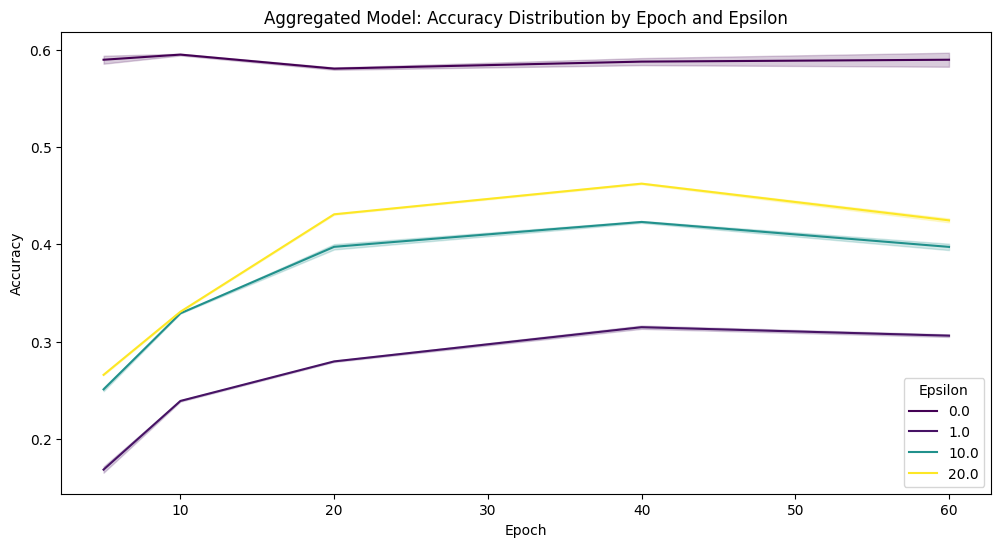

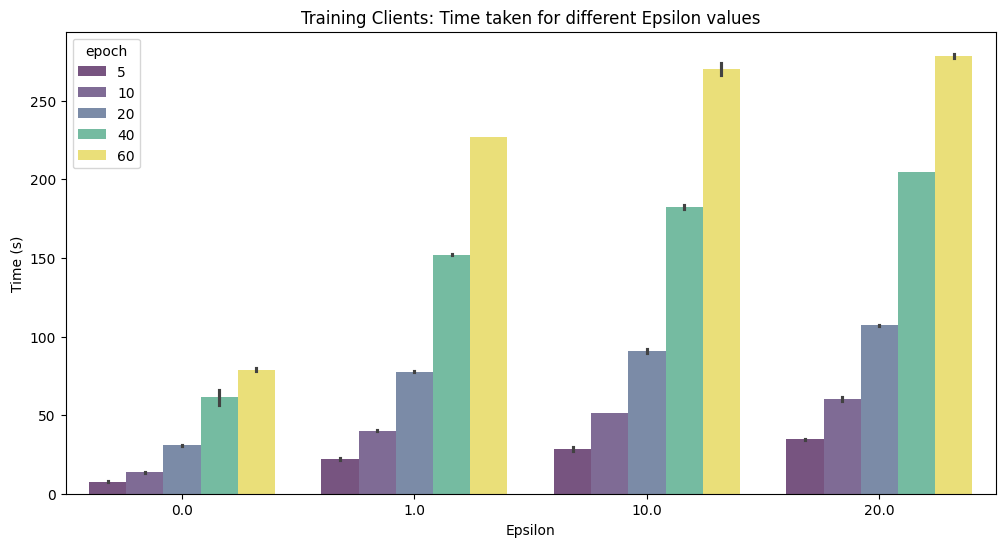

In [ ]:
##  Plotting the data gathered above  ##

url = "https://raw.githubusercontent.com/yannuma/PrivacyProject/main/Model_Creation/Dataframes_results/df_results_FL.csv"
df_results_FL = pd.read_csv(url)
url = "https://raw.githubusercontent.com/yannuma/PrivacyProject/main/Model_Creation/Dataframes_results/df_results_FL_DP.csv"
df_results_FL_DP = pd.read_csv(url)

#Accuracy Boxplot by Epoch and Mode (without Privacy)
plt.figure(figsize=(12, 6))
sns.boxplot(x="epoch", y="accuracy", hue="Mode", data=df_results_FL,
            dodge=False, palette=['#7C74DB', '#DB7FD8'])
plt.title("Accuracy Boxplot by Epoch and Mode")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Accuracy Boxplot by Epochs with Privacy
#Sadly it doesn't look nice
plt.figure(figsize=(12, 6))
sns.boxplot(x="epoch", y="accuracy", hue="epsilon",
            data=df_results_FL_DP[df_results_FL_DP['Mode'] == 'Aggregated Model'],
            dodge=False, width=0.5)
plt.title("Aggregated Model: Accuracy Distribution by Epoch and Epsilon")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title='Epsilon')
plt.show()

#Accuracy lineplot by Epochs with Privacy
plt.figure(figsize=(12, 6))
sns.lineplot(x="epoch", y="accuracy", hue="epsilon",
             data=df_results_FL_DP[df_results_FL_DP['Mode'] == 'Aggregated Model'],  palette="viridis")
plt.title("Aggregated Model: Accuracy Distribution by Epoch and Epsilon")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title='Epsilon')
plt.show()

combined_df = pd.concat([df_results_FL[df_results_FL['Mode'] == 'Aggregated Model'],
                         df_results_FL_DP[df_results_FL_DP['Mode'] == 'Aggregated Model']])

combined_df['epsilon'] = combined_df['epsilon'].fillna(0)

#Accuracy lineplot for combined data
plt.figure(figsize=(12, 6))
sns.lineplot(x="epoch", y="accuracy", hue="epsilon", data=combined_df,  palette="viridis")
plt.title("Aggregated Model: Accuracy Distribution by Epoch and Epsilon")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title='Epsilon')
plt.show()

combined_df_time = pd.concat([df_results_FL[df_results_FL['Mode'] != 'Aggregated Model'],
                         df_results_FL_DP[df_results_FL_DP['Mode'] != 'Aggregated Model']])
combined_df_time['epsilon'] = combined_df_time['epsilon'].fillna(0)
combined_df_time = combined_df_time.sort_values(by=["epsilon", "time"])

#Execution time barplot for combined data
plt.figure(figsize=(12, 6))
sns.barplot(x="epsilon", y="time", hue="epoch", data=combined_df_time, palette="viridis", alpha=0.7)
plt.title("Training Clients: Time taken for different Epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Time (s)")
plt.show()